# Implement the EM algorithm for fitting a Gaussian mixture model for the MNIST handwritten digits dataset

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn


In [10]:

np.random.seed(0) # for reproducibility

data  = np.loadtxt("data.dat")    # [784, 1990]
label = np.loadtxt("label.dat")   # [1900, ]


## Filtering to only 2 cases, digits 2 and 6

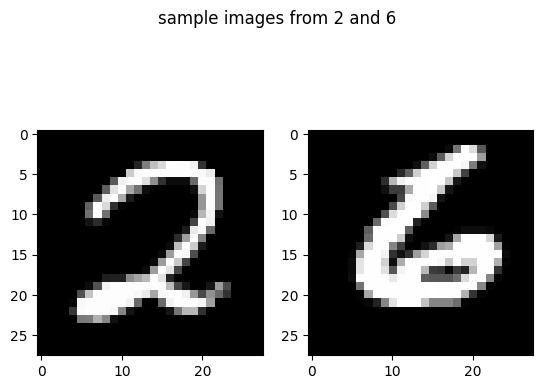

In [11]:

# # display an image from both '2' and '6'
fig, ax = plt.subplots(1, 2)
ax[0].imshow((data[:,1].reshape(28,28).T),cmap='gray')
ax[1].imshow((data[:,-1].reshape(28,28).T),cmap='gray')
fig.suptitle('sample images from 2 and 6')
plt.show()


# PCA to reduce the dimensionality of the data before applying to EM

In [12]:

# # pca
n, m = data.shape
datamean = np.mean(data, axis=1)
datamean = datamean[:, np.newaxis]
xc = data - datamean
C = xc@xc.T/m
s, u = np.linalg.eig(C)
index = np.argsort(s)[::-1]
s = s[index]


npc = 4 # pca truncation number
ut = u[:, 0:npc]
ds = np.diag(s[0:npc])
d_inv_half = np.diag(s[0:npc]**(-1/2))

data_rd = (xc.T @ ut @ d_inv_half).T.real 
# reduced-dimensional data, transpose to keep the dimension definition consistent


# Applying EM (Expectation-Maximization) on projected data from PCA with 4-dimensions

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
[0.48282112 0.51717888]


C:\Users\stuti\AppData\Local\Temp\ipykernel_26232\3411766963.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  mu_rec[ii] = datamean.ravel() + tmp # add the data mean back on


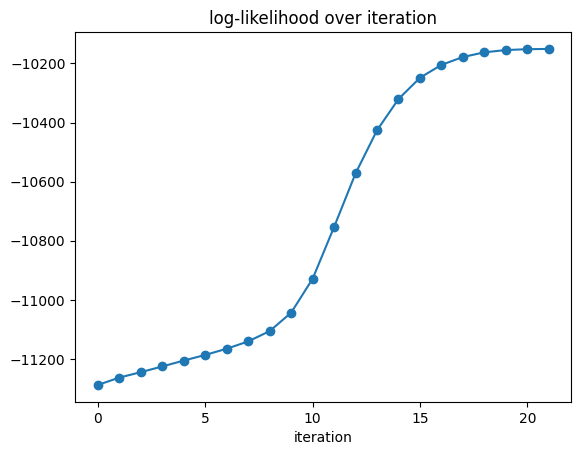

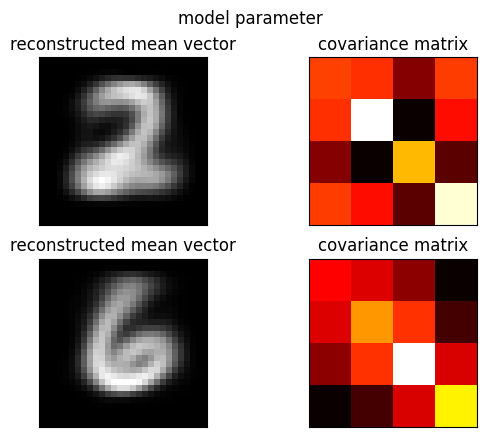

In [13]:


# ## GMM - EM
# initialzation
k = 2  # number of mixture components
mu_old = np.random.randn(k, npc)
mu_new = mu_old + 10


sigma_old = np.empty((k, npc, npc))
for ii in range(k):
    tmp = np.random.randn(npc, npc)
    tmp = tmp@tmp.T 
    sigma_old[ii] = tmp
# sigma_new = sigma_old + 10
sigma_new = np.empty((k, npc, npc))

pi_old = np.random.random(k)
pi_old = pi_old/pi_old.sum()

pi_new = np.zeros(2)

tau = np.zeros((m,k), dtype=float)


ll_all = []
  
itt = 1
maxIter =100
tol = 1e-2
while itt<maxIter:
    print('Iteration: ',str(itt))
    # ## E-step    
    for ii in range(k):
        fpdf = mvn(mu_old[ii], sigma_old[ii]) # i-th mixture pdf
        tau[:,ii] = fpdf.pdf(data_rd.T)
    tau = tau*pi_old   # tau_{i,k}, In E-step
    tmp = tau.sum(axis=1)
    tmp = tmp[:, np.newaxis]
    tau = tau / tmp    # normalizing over all the k
    
    # ## M-step
    #  update mean vectors
    mu_new = tau.T @ data_rd.T
    tmp = tau.sum(axis=0)
    tmp = tmp[:, np.newaxis]
    mu_new = mu_new/tmp
    
    # update cov matrix
    for ii in range(k):
        tmp = data_rd.T - mu_new[ii]
        sigma_new[ii] = tmp.T @ np.diag(tau[:,ii]) @tmp/ tau[:,ii].sum()
    
    # update priors
    pi_new = tau.sum(axis=0)/m
    
    # check log-likelihood
    likelihood = 0  # likelihood
    for ii in range(k):
        ftmp = mvn(mu_new[ii], sigma_new[ii])
        ll_tmp = ftmp.pdf(data_rd.T) * pi_new[ii]
        likelihood = likelihood+ ll_tmp
    ll_all.append(np.sum(np.log(likelihood)))
    
    if np.linalg.norm(mu_new.ravel() - mu_old.ravel()) < tol:
        break
    mu_old = mu_new
    sigma_old = sigma_new
    pi_old = pi_new
    itt = itt+1

print(pi_new)
    
plt.plot(ll_all,'-o')
plt.title('log-likelihood over iteration')
plt.xlabel('iteration')
# plt.savefig('llh_plot.pdf')

# ### recover the mean vector

mu_rec = np.empty((k, n))
sigma_rec = np.empty((k, n, n))
fig2, ax2 = plt.subplots(2, 2)
for ii in range(k):
    
    # reconstructing image by reversing the PCA procedures
    #tmp = ut @ mu_new[ii]
    tmp = ut @ np.sqrt(ds) @ mu_new[ii] # multiply the eigenvalues 
    mu_rec[ii] = datamean.ravel() + tmp # add the data mean back on
    im = mu_rec[ii].reshape(28, 28)
    ax2[ii, 0].imshow(im.T, cmap='gray')
    ax2[ii, 0].set_title('reconstructed mean vector')
    ax2[ii, 0].set_xticks([])
    ax2[ii, 0].set_yticks([])
    
    # sigma_rec[ii] = ut @ np.sqrt(ds) @ sigma_new[ii] @ np.sqrt(ds) @ ut.T
    ax2[ii, 1].imshow(sigma_new[ii], cmap='hot')
    ax2[ii, 1].set_title('covariance matrix')
    ax2[ii, 1].set_xticks([])
    ax2[ii, 1].set_yticks([])
fig2.suptitle('model parameter')  
# plt.savefig('recon_mean.pdf')
plt.show()  
    



## The component weights are 0.48282112 & 0.51717888

In [14]:
# ### classification accuracy
idx2 = np.where(label==2)[0]
idx6 = np.where(label==6)[0]

print('accuracy with pca-GMM')
match2 = tau[idx2,0]>=tau[idx2,1]
acc2 = match2.sum()/idx2.size
acc2 = np.max([acc2, 1-acc2]) 

'''since we do not have the label information from GMM, 
we choose the max accuracy rate, which can be seen as an voting mechanism'''

print('mis-classification rate for #2: {:.4%}'.format(1-acc2) )

match6 = tau[idx6,0]>=tau[idx6,1]
acc6 = match6.sum()/idx6.size
acc6 = np.max([acc6, 1-acc6])
print('mis-classification rate for #6: {:.4%}'.format(1-acc6) )


# with kmeans
km = KMeans(n_clusters=2).fit(data_rd.T)
print('accuracy with kmeans')
kmean_match2 = km.labels_[idx2]==1
km_acc2 = kmean_match2.sum()/idx2.size
km_acc2 = np.max([km_acc2, 1-km_acc2])
print('mis-classification rate for #2: {:.4%}'.format(1-km_acc2) )

kmean_match6 = km.labels_[idx6]==1
km_acc6 = kmean_match6.sum()/idx6.size
km_acc6 = np.max([km_acc6, 1-km_acc6])
print('mis-classification rate for #6: {:.4%}'.format(1-km_acc6) )

accuracy with pca-GMM
mis-classification rate for #2: 6.8798%
mis-classification rate for #6: 0.8351%


C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


accuracy with kmeans
mis-classification rate for #2: 6.9767%
mis-classification rate for #6: 4.5929%


## We can see here that GMM performs much better than k-means for the digit ’6’, with relatively similar performance for digit ’2’.